In [1]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/rl_sim/thesis_ws/src/ML/UTILITIES')
from PreProcessingFunctions import WS, WS_B

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, free_gpu_memory, save_summary_and_results
from XAI_FCN import plot_grad_cam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from scipy.signal import butter, filtfilt
import traceback

import tensorflow
import tensorflow as tf
gpus = tensorflow.config.list_physical_devices('GPU')
# if gpus:    
#     for gpu in gpus:
#         tensorflow.config.set_logical_device_configuration(
#             gpu,
#             [tensorflow.config.LogicalDeviceConfiguration(memory_limit=48*1024)])  # Adjust memory limit as needed


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalMaxPooling2D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import BinaryCrossentropy
from tensorflow.keras.metrics    import AUC
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model

def load_data(data_folder):
    X_data_list = []
    y_data_list = []
    
    # Traverse the data folder
    for file in os.listdir(data_folder):
        if file.endswith(".npz"):
            file_path = os.path.join(data_folder, file)
            with np.load(file_path) as data:
                X_data_list.append(data['X'])
                y_data_list.append(data['y'])
    
    # Stack the data into arrays
    X_data = np.vstack(X_data_list)
    y_data = np.hstack(y_data_list)
    
    return X_data, y_data

# Define the folder containing your preprocessed .npz files
data_folder = '/home/rl_sim/thesis_ws/src/ML_ACTIONS/DATA/SPEED_HYB_1FTP_2FT_ScalNorm'

# Load the dataset
X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)  # Should print the shape as (samples, time steps, features)
print("y_data shape:", y_data.shape)  # Should print the shape as (samples,)
print("X_data[0] shape:", X_data[0].shape)  # Should print the shape as (time steps, features)

# Split the data into training, validation, and test sets
TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print information about the dataset splits
print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

# Define the dimensions based on your scaleogram dimensions and window size
scales_dim = 128
target_length = 1800
num_1D_features = 9
num_2D_signals = 6  # Number of 2D signals (e.g., Force_X, Force_Y, Force_Z, Torque_X, Torque_Y, Torque_Z)
num_classes = int(np.max(y_data)) + 1  # Number of classes

# Separate 1D and 2D data
X_train_1D = X_train[:, :, :num_1D_features]  # First 9 features
X_val_1D = X_val[:, :, :num_1D_features]
X_test_1D = X_test[:, :, :num_1D_features]

X_train_2D = X_train[:, :, num_1D_features:].reshape(-1, target_length, scales_dim * num_2D_signals)
X_val_2D = X_val[:, :, num_1D_features:].reshape(-1, target_length, scales_dim * num_2D_signals)
X_test_2D = X_test[:, :, num_1D_features:].reshape(-1, target_length, scales_dim * num_2D_signals)


# Print the shapes of the 1D and 2D data
print("X_train_1D shape:", X_train_1D.shape)  # Should print something like (samples, target_length, 9)
print("X_val_1D shape:", X_val_1D.shape)
print("X_test_1D shape:", X_test_1D.shape)

print("X_train_2D shape:", X_train_2D.shape)  # Should print something like (samples, target_length, scales_dim, 1)
print("X_val_2D shape:", X_val_2D.shape)
print("X_test_2D shape:", X_test_2D.shape)

# Example to print shapes of individual data points
print("X_train_1D[0] shape:", X_train_1D[0].shape)  # Should print (target_length, 9)
print("X_train_2D[0] shape:", X_train_2D[0].shape)  # Should print (target_length, scales_dim, 1)
OUT_N = num_classes  # Calculate the number of classes
DISP_LABELS = list(range(OUT_N))  # Create a list of labels from 0 to OUT_N-1
print("OUT_N:", OUT_N)
print("DISP_LABELS:", DISP_LABELS)

# 777 = 9 + 128*6


def compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=50, batch_size=32, patience=8, disp_labels=DISP_LABELS):
    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)

    # Predict labels for test data
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    FontSz = 2.5

    # Plot training history
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    # Plot Loss Value
    axs[0].plot(history.history["loss"], label="loss (Training)", linewidth=FontSz)
    axs[0].plot(history.history["val_loss"], label="val_loss",linewidth=FontSz)
    axs[0].set_title("Loss Value")
    axs[0].set_xlabel('Epoch')
    axs[0].legend()

    # Plot Accuracy
    axs[1].plot(history.history["accuracy"], label="accuracy" ,linewidth=FontSz)
    axs[1].plot(history.history["val_accuracy"], label="val_accuracy" ,linewidth=FontSz)
    axs[1].set_title("Accuracy")
    axs[1].set_xlabel('Epoch')
    axs[1].legend()
    plt.tight_layout()
    plt.show()

    # Calculate additional metrics
    f1 = f1_score(y_test, y_pred_labels, average='macro') 
    accuracy = accuracy_score(y_test, y_pred_labels)

    print("Test loss:", loss)
    print("Test accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Classification Report:\n", classification_report(y_test, y_pred_labels))

    # Confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=disp_labels, )
    disp.plot(cmap=plt.cm.viridis)  # You can adjust the colormap as needed
    for text in disp.text_.ravel():
        text.set_fontsize(14)  # Set font size (adjust number as needed)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    return history, loss, accuracy, f1, y_pred_labels

2024-09-16 01:18:35.960924: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-16 01:18:35.986640: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-16 01:18:36.395911: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-09-16 01:18:36.698034: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more 

X_data shape: (465, 1800, 777)
y_data shape: (465,)
X_data[0] shape: (1800, 777)
TOTAL DATA: 465  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (279, 1800, 777)    ||  Dimensions of y_train: (279,)
Dimensions of X_test:  (93, 1800, 777)    ||  Dimensions of y_test:  (93,)
Dimensions of X_val:   (93, 1800, 777)    ||  Dimensions of y_val:   (93,)
X_train_1D shape: (279, 1800, 9)
X_val_1D shape: (93, 1800, 9)
X_test_1D shape: (93, 1800, 9)
X_train_2D shape: (279, 1800, 768)
X_val_2D shape: (93, 1800, 768)
X_test_2D shape: (93, 1800, 768)
X_train_1D[0] shape: (1800, 9)
X_train_2D[0] shape: (1800, 768)
OUT_N: 4
DISP_LABELS: [0, 1, 2, 3]


## 2 BRANCHES new

2024-09-10 17:28:53.513533: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-10 17:28:53.513693: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-10 17:28:53.513817: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "TwoBranchModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1D            │ (None, 1800, 9)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_2D            │ (None, 1800, 768, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_1D (Conv1D)   │ (None, 177, 64)   │     23,104 │ input_1D[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_2D (Conv2D)   │ (None, 225, 96,   │     25,664 │ input_2D[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 177, 64)   │          0 │ conv1_1D[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 225, 96,   │          0 │ conv1_2D[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 88, 64)    │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 24,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1D (Conv1D)   │ (None, 21, 128)   │     65,664 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_2D (Conv2D)   │ (None, 12, 5,     │    819,328 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 21, 128)   │          0 │ conv2_1D[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 12, 5,     │          0 │ conv2_2D[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3_1D (Conv1D)   │ (None, 19, 128)   │     49,280 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3_2D (Conv2D)   │ (None, 6, 3, 256) │    524,544 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 19, 128)   │          0 │ conv3_1D[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 6, 3, 256) │          0 │ conv3_2D[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ activation_2[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ activation_5[0][… │
│ (GlobalMaxPooling2… │                   │            │                 

 Total params: 1,565,380 (5.97 MB)

 Trainable params: 1,565,380 (5.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70


I0000 00:00:1725982136.401500 1335691 service.cc:145] XLA service 0x7f39ec007290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725982136.401563 1335691 service.cc:153]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
I0000 00:00:1725982136.401567 1335691 service.cc:153]   StreamExecutor device (1): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-09-10 17:28:56.445047: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-10 17:28:56.554838: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3365 - loss: 1.5670

I0000 00:00:1725982141.005895 1335691 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 771ms/step - accuracy: 0.3442 - loss: 1.5326 - val_accuracy: 0.7957 - val_loss: 0.8968
Epoch 2/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6986 - loss: 0.8488 - val_accuracy: 0.7527 - val_loss: 0.6041
Epoch 3/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7691 - loss: 0.6346 - val_accuracy: 0.6022 - val_loss: 0.8172
Epoch 4/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7516 - loss: 0.5819 - val_accuracy: 0.7204 - val_loss: 0.6256
Epoch 5/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8204 - loss: 0.4361 - val_accuracy: 0.8925 - val_loss: 0.3354
Epoch 6/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7705 - loss: 0.5141 - val_accuracy: 0.8925 - val_loss: 0.2801
Epoch 7/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7708 - loss: 0.4728 - val_accuracy: 0.9247 - val_loss: 0.2408
Epoch 8/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8670 - loss: 0.3255 - val_accuracy: 0.9140 - val_loss: 0.2666
Epoch 9/7

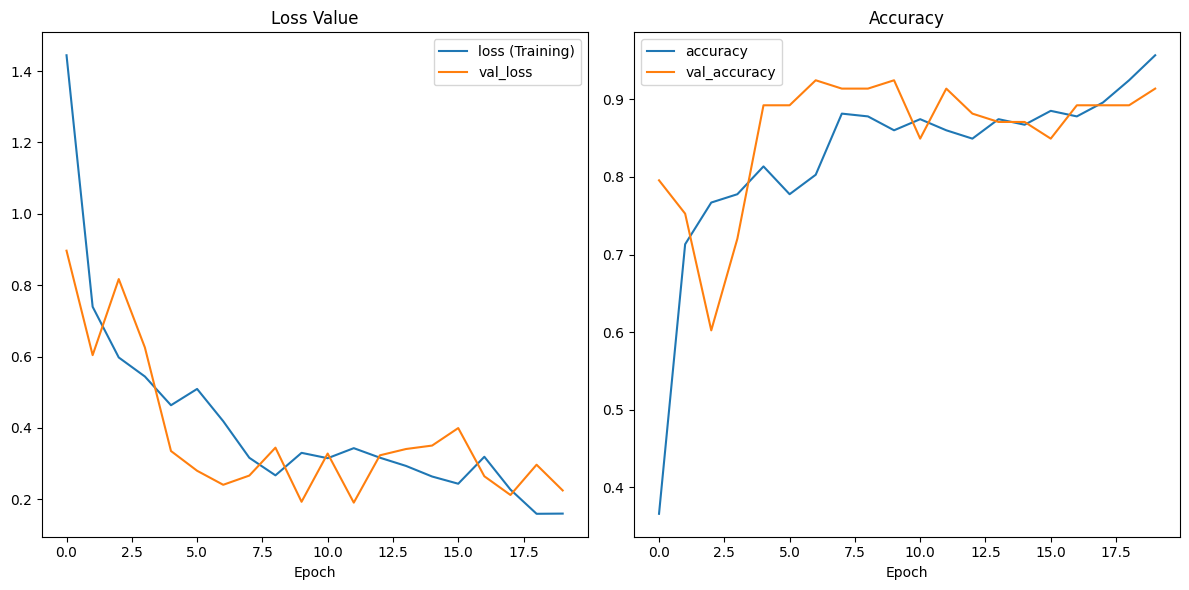

Test loss: 0.1828208863735199
Test accuracy: 0.9354838709677419
F1 Score: 0.9284717607973422
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        29
         1.0       1.00      0.95      0.98        22
         2.0       0.79      1.00      0.88        22
         3.0       1.00      0.75      0.86        20

    accuracy                           0.94        93
   macro avg       0.95      0.93      0.93        93
weighted avg       0.95      0.94      0.94        93



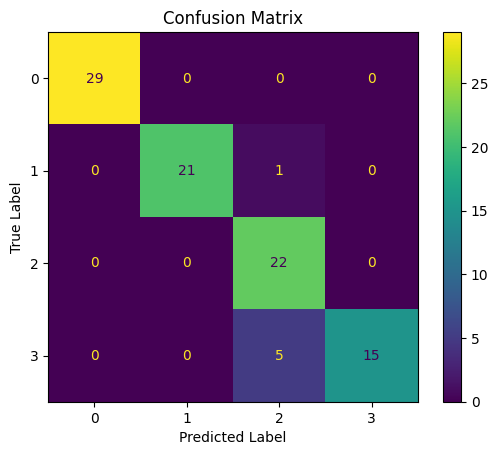

In [2]:
def build_TwoBranchModel(F_input_shape, S_input_shape, num_classes):
    # 1D Data Branch
    input_1D = tf.keras.layers.Input(shape=F_input_shape, name='input_1D')
    conv1_1D = tf.keras.layers.Conv1D(64, kernel_size=40, strides=10, name='conv1_1D')(input_1D)
    conv1_1D = tf.keras.layers.Activation('relu')(conv1_1D)
    pool1_1D = tf.keras.layers.MaxPooling1D(pool_size=2)(conv1_1D)

    conv2_1D = tf.keras.layers.Conv1D(128, kernel_size=8, strides=4, name='conv2_1D')(pool1_1D)
    conv2_1D = tf.keras.layers.Activation('relu')(conv2_1D)
    #pool2_1D = tf.keras.layers.GlobalMaxPooling1D()(conv2_1D)

    conv3_1D = tf.keras.layers.Conv1D(128, kernel_size=3, strides=1, name='conv3_1D')(conv2_1D)
    conv3_1D = tf.keras.layers.Activation('relu')(conv3_1D)
    pool3_1D = tf.keras.layers.GlobalMaxPooling1D()(conv3_1D)

    flatten_1D = tf.keras.layers.Flatten()(pool3_1D)

    # 2D Data Branch (Scaleograms)
    input_2D = tf.keras.layers.Input(shape=S_input_shape, name='input_2D')
    conv1_2D = tf.keras.layers.Conv2D(64, kernel_size=(20, 20), strides=(8,8), padding='same', name='conv1_2D')(input_2D)
    conv1_2D = tf.keras.layers.Activation('relu')(conv1_2D)
    pool1_2D = tf.keras.layers.MaxPooling2D(pool_size=(4, 4))(conv1_2D)

    conv2_2D = tf.keras.layers.Conv2D(128, kernel_size=(10, 10), strides=(5,5), padding='same', name='conv2_2D')(pool1_2D)
    conv2_2D = tf.keras.layers.Activation('relu')(conv2_2D)
    
    conv3_2D = tf.keras.layers.Conv2D(256, kernel_size=(4, 4), strides=(2,2), padding='same', name='conv3_2D')(conv2_2D)
    conv3_2D = tf.keras.layers.Activation('relu')(conv3_2D)
    pool3_2D = tf.keras.layers.GlobalMaxPooling2D()(conv3_2D)

    flatten_2D = tf.keras.layers.Flatten()(pool3_2D)

    # Merge branches
    merged = tf.keras.layers.concatenate([flatten_1D, flatten_2D])

    # Fully Connected Layers
    fc = tf.keras.layers.Dense(128, activation='relu')(merged)
    fc = tf.keras.layers.Dense(64, activation='relu')(fc)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(fc)

    # Define the Model
    model = tf.keras.Model(inputs=[input_1D, input_2D], outputs=output, name='TwoBranchModel')
    return model

F_input_shape = (target_length, 9)  # For the 1D branch (force, torque, and pose data)
S_input_shape = (target_length, scales_dim * num_2D_signals, 1)  # For the 2D branch (scaleograms)


_X_train = [X_train_1D, X_train_2D]
_X_val = [X_val_1D, X_val_2D]
_X_test = [X_test_1D, X_test_2D]

# Create and compile the model
model = build_TwoBranchModel(F_input_shape, S_input_shape, num_classes)
model.summary()
history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(model, _X_train, y_train, _X_val, y_val, _X_test, y_test, epochs=70, batch_size=32, patience=8, disp_labels=DISP_LABELS)


In [5]:
# model_name = "HYB_2B_easy2_ALLdata_98%"
# save_summary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_TwoBranchModel)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


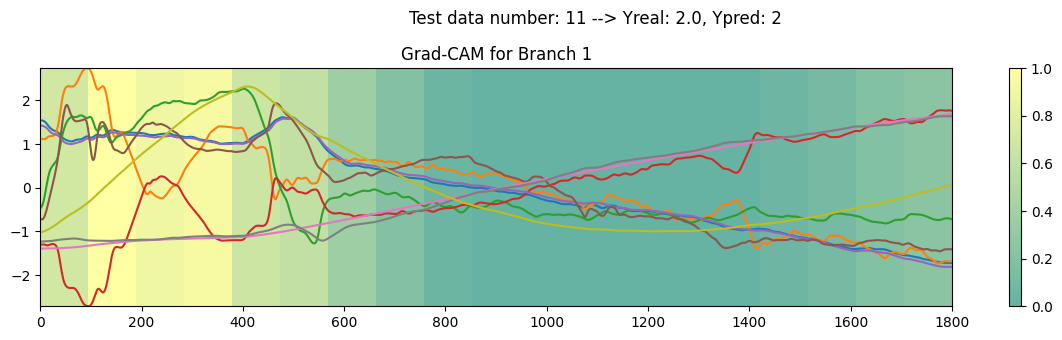

In [16]:
layer_names = ['conv3_1D']
plot_grad_cam(model, [X_test_1D, X_test_2D],11, y_test, layer_names)

In [ ]:
# import sys
# sys.path.append('/home/rl_sim/thesis_ws/src/ML_ACTIONS')
# from HYBRID_GRAD_CAM import plot_grad_cam
# conv_layers = ['conv3_1D', 'conv3_2D']

# # Call plot_grad_cam function to visualize the Grad-CAM heatmaps for sample index 31
# sample_idx = 31  # Example index of the sample to visualize
# plot_grad_cam(model, [X_test_1D, X_test_2D], sample_idx, y_test, conv_layers)

: 

## MANY BRANCHES

Model: "MultiBranchModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_forces_1D     │ (None, 1800, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_forces_1D     │ (None, 178, 64)   │      5,824 │ input_forces_1D[… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_60       │ (None, 178, 64)   │          0 │ conv1_forces_1D[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_torques_1D    │ (None, 1800, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_deltaPoses_1D │ (None, 1800, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_forces_2D     │ (None, 1800, 384, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_torques_2D    │ (None, 1800, 384, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_54          │ (None, 178, 64)   │          0 │ activation_60[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_torques_1D    │ (None, 177, 64)   │      7,744 │ input_torques_1D… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_deltaPoses_1D │ (None, 177, 64)   │      7,744 │ input_deltaPoses… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_forces_2D     │ (None, 225, 48,   │      6,464 │ input_forces_2D[… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_torques_2D    │ (None, 225, 48,   │     25,664 │ input_torques_2D… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_forces_1D     │ (None, 43, 128)   │     82,048 │ dropout_54[0][0]  │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_63       │ (None, 177, 64)   │          0 │ conv1_torques_1D… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_65       │ (None, 177, 64)   │          0 │ conv1_deltaPoses… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_67       │ (None, 225, 48,   │          0 │ conv1_forces_2D[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_69       │ (None, 225, 48,   │          0 │ conv1_torques_2D

 Total params: 1,717,764 (6.55 MB)

 Trainable params: 1,717,764 (6.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.3803 - loss: 1.3483 - val_accuracy: 0.7849 - val_loss: 0.7199
Epoch 2/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7563 - loss: 0.6969 - val_accuracy: 0.8065 - val_loss: 0.5244
Epoch 3/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8093 - loss: 0.4702 - val_accuracy: 0.8387 - val_loss: 0.5194
Epoch 4/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7727 - loss: 0.5271 - val_accuracy: 0.8710 - val_loss: 0.3773
Epoch 5/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8867 - loss: 0.2787 - val_accuracy: 0.8710 - val_loss: 0.3831
Epoch 6/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9020 - loss: 0.2871 - val_accuracy: 0.8495 - val_loss: 0.3093
Epoch 7/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8975 - loss: 0.2267 - val_accuracy: 0.8817 - val_loss: 0.3000
Epoch 8/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9067 - loss: 0.2676 - val_accuracy: 0.8602 - val_loss: 0.4391
E

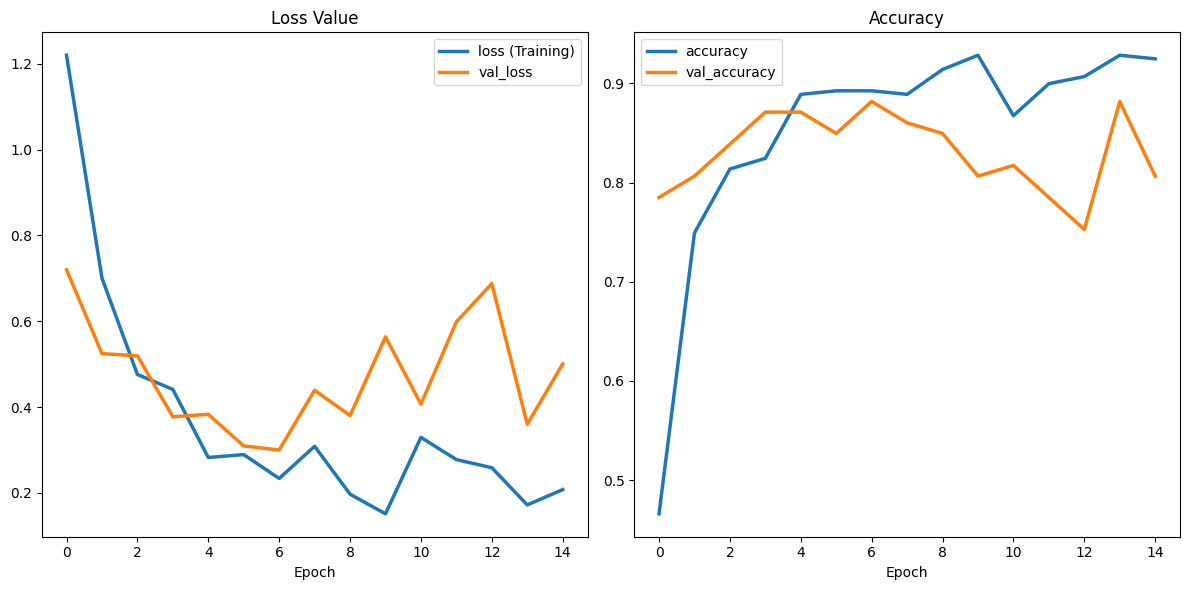

Test loss: 0.2016133815050125
Test accuracy: 0.9139784946236559
F1 Score: 0.9037815126050419
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        29
         1.0       1.00      0.91      0.95        22
         2.0       0.76      1.00      0.86        22
         3.0       0.93      0.70      0.80        20

    accuracy                           0.91        93
   macro avg       0.92      0.90      0.90        93
weighted avg       0.93      0.91      0.91        93



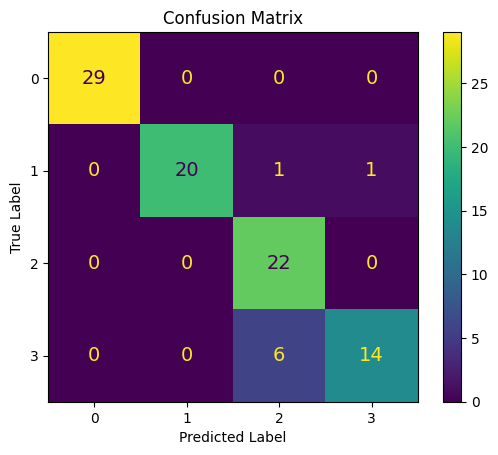

In [40]:
def build_MultiBranchModel(F_input_shape, T_input_shape, P_input_shape, S_input_shape_F, S_input_shape_T, num_classes):
    # 1D Force Branch
    input_forces_1D = tf.keras.layers.Input(shape=F_input_shape, name='input_forces_1D')
    conv1_forces_1D = tf.keras.layers.Conv1D(64, kernel_size=30, strides=10, name='conv1_forces_1D')(input_forces_1D)
    conv1_forces_1D = tf.keras.layers.Activation('relu')(conv1_forces_1D)
    dropout1_forces_1D = tf.keras.layers.Dropout(0.1)(conv1_forces_1D)
    conv2_forces_1D = tf.keras.layers.Conv1D(128, kernel_size=10, strides=4, name='conv2_forces_1D')(dropout1_forces_1D)
    conv2_forces_1D = tf.keras.layers.Activation('relu')(conv2_forces_1D)
    dropout2_forces_1D = tf.keras.layers.Dropout(0.1)(conv2_forces_1D)
    conv3_forces_1D = tf.keras.layers.Conv1D(256, kernel_size=3, strides=1, name='conv3_forces_1D')(dropout2_forces_1D)
    conv3_forces_1D = tf.keras.layers.Activation('relu')(conv3_forces_1D)
    pool1_forces_1D = tf.keras.layers.GlobalMaxPooling1D()(conv3_forces_1D)

    flatten_forces_1D = tf.keras.layers.Flatten()(pool1_forces_1D)

    # 1D Torque Branch
    input_torques_1D = tf.keras.layers.Input(shape=T_input_shape, name='input_torques_1D')
    conv1_torques_1D = tf.keras.layers.Conv1D(64, kernel_size=40, strides=10, name='conv1_torques_1D')(input_torques_1D)
    conv1_torques_1D = tf.keras.layers.Activation('relu')(conv1_torques_1D)
    dropout1_torques_1D = tf.keras.layers.Dropout(0.1)(conv1_torques_1D)
    conv2_torques_1D = tf.keras.layers.Conv1D(128, kernel_size=20, strides=4, name='conv2_torques_1D')(dropout1_torques_1D)
    conv2_torques_1D = tf.keras.layers.Activation('relu')(conv2_torques_1D)
    dropout2_torques_1D = tf.keras.layers.Dropout(0.1)(conv2_torques_1D)
    pool1_torques_1D = tf.keras.layers.GlobalMaxPooling1D()(dropout2_torques_1D)

    flatten_torques_1D = tf.keras.layers.Flatten()(pool1_torques_1D)

    # 1D Delta Pose Branch
    input_deltaPoses_1D = tf.keras.layers.Input(shape=P_input_shape, name='input_deltaPoses_1D')
    conv1_deltaPoses_1D = tf.keras.layers.Conv1D(64, kernel_size=40, strides=10, name='conv1_deltaPoses_1D')(input_deltaPoses_1D)
    conv1_deltaPoses_1D = tf.keras.layers.Activation('relu')(conv1_deltaPoses_1D)
    dropout1_deltaPoses_1D = tf.keras.layers.Dropout(0.1)(conv1_deltaPoses_1D)
    conv2_deltaPoses_1D = tf.keras.layers.Conv1D(128, kernel_size=20, strides=4, name='conv2_deltaPoses_1D')(dropout1_deltaPoses_1D)
    conv2_deltaPoses_1D = tf.keras.layers.Activation('relu')(conv2_deltaPoses_1D)
    dropout2_deltaPoses_1D = tf.keras.layers.Dropout(0.1)(conv2_deltaPoses_1D)
    pool1_deltaPoses_1D = tf.keras.layers.GlobalMaxPooling1D()(dropout2_deltaPoses_1D)

    flatten_deltaPoses_1D = tf.keras.layers.Flatten()(pool1_deltaPoses_1D)

    # 2D Force Scaleogram Branch
    input_forces_2D = tf.keras.layers.Input(shape=S_input_shape_F, name='input_forces_2D')
    conv1_forces_2D = tf.keras.layers.Conv2D(64, kernel_size=(10, 10), strides=(8, 8), padding='same', name='conv1_forces_2D')(input_forces_2D)
    conv1_forces_2D = tf.keras.layers.Activation('relu')(conv1_forces_2D)
    dropout1_forces_2D = tf.keras.layers.Dropout(0.1)(conv1_forces_2D)
    conv2_forces_2D = tf.keras.layers.Conv2D(128, kernel_size=(8, 8), strides=(4, 4), padding='same', name='conv2_forces_2D')(dropout1_forces_2D)
    conv2_forces_2D = tf.keras.layers.Activation('relu')(conv2_forces_2D)
    dropout2_forces_2D = tf.keras.layers.Dropout(0.1)(conv2_forces_2D)
    pool1_forces_2D = tf.keras.layers.GlobalMaxPooling2D()(dropout2_forces_2D)

    flatten_forces_2D = tf.keras.layers.Flatten()(pool1_forces_2D)

    # 2D Torque Scaleogram Branch
    input_torques_2D = tf.keras.layers.Input(shape=S_input_shape_T, name='input_torques_2D')
    conv1_torques_2D = tf.keras.layers.Conv2D(64, kernel_size=(20, 20), strides=(8, 8), padding='same', name='conv1_torques_2D')(input_torques_2D)
    conv1_torques_2D = tf.keras.layers.Activation('relu')(conv1_torques_2D)
    dropout1_torques_2D = tf.keras.layers.Dropout(0.1)(conv1_torques_2D)
    conv2_torques_2D = tf.keras.layers.Conv2D(128, kernel_size=(8, 8), strides=(4, 4), padding='same', name='conv2_torques_2D')(dropout1_torques_2D)
    conv2_torques_2D = tf.keras.layers.Activation('relu')(conv2_torques_2D)
    dropout2_torques_2D = tf.keras.layers.Dropout(0.1)(conv2_torques_2D)
    pool1_torques_2D = tf.keras.layers.GlobalMaxPooling2D()(dropout2_torques_2D)

    flatten_torques_2D = tf.keras.layers.Flatten()(pool1_torques_2D)

    # Merge all branches
    merged = tf.keras.layers.concatenate([
        flatten_forces_1D, flatten_torques_1D, 
        flatten_deltaPoses_1D, flatten_forces_2D, flatten_torques_2D
    ])

    # Fully Connected Layers
    fc = tf.keras.layers.Dense(128, activation='relu')(merged)
    fc = tf.keras.layers.Dense(64, activation='relu')(fc)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(fc)

    # Define the Model
    model = tf.keras.Model(
        inputs=[
            input_forces_1D, input_torques_1D, 
            input_deltaPoses_1D, input_forces_2D, input_torques_2D
        ], 
        outputs=output, 
        name='MultiBranchModel'
    )
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


# Define input shapes based on the above structure
F_input_shape = (target_length, 3)  # For the 1D branch (forces)
T_input_shape = (target_length, 3)  # For the 1D branch (torques)
P_input_shape = (target_length, 3)  # For the 1D branch (delta poses)

# The 2D branches use the scaleogram input shapes
S_input_shape_F = (target_length, scales_dim*3, 1)  # For the 2D branch (force scaleograms)
S_input_shape_T = (target_length, scales_dim*3, 1)  # For the 2D branch (torque scaleograms)

# X_train = np.array(X_train)
# X_val = np.array(X_val)
# X_test = np.array(X_test)

X_train_1D_forces = X_train[:, :, 0:3]  # Force_X, Force_Y, Force_Z
X_train_1D_torques = X_train[:, :, 3:6]  # Torque_X, Torque_Y, Torque_Z
X_train_1D_deltaPoses = X_train[:, :, 6:9]  # Pose_X, Pose_Y, Pose_Z

X_val_1D_forces = X_val[:, :, 0:3]
X_val_1D_torques = X_val[:, :, 3:6]
X_val_1D_deltaPoses = X_val[:, :, 6:9]

X_test_1D_forces = X_test[:, :, 0:3]
X_test_1D_torques = X_test[:, :, 3:6]
X_test_1D_deltaPoses = X_test[:, :, 6:9]

# Separate the 2D features: The remaining features are for scaleograms
X_train_2D = X_train[:, :, num_1D_features:]  # (samples, target_length, 768)
X_val_2D = X_val[:, :, num_1D_features:]
X_test_2D = X_test[:, :, num_1D_features:]

# Reshape the 2D features to have a shape of (samples, target_length, scales_dim, 1)
X_train_2D_forces = X_train_2D[:, :, 0:3*scales_dim].reshape(-1, target_length, 3*scales_dim, 1)
X_train_2D_torques = X_train_2D[:, :, 3*scales_dim:6*scales_dim].reshape(-1, target_length, 3*scales_dim, 1)

X_val_2D_forces = X_val_2D[:, :, 0:3*scales_dim].reshape(-1, target_length, 3*scales_dim, 1)
X_val_2D_torques = X_val_2D[:, :, 3*scales_dim:6*scales_dim].reshape(-1, target_length, 3*scales_dim, 1)

X_test_2D_forces = X_test_2D[:, :, 0:3*scales_dim].reshape(-1, target_length, 3*scales_dim, 1)
X_test_2D_torques = X_test_2D[:, :, 3*scales_dim:6*scales_dim].reshape(-1, target_length, 3*scales_dim, 1)

# Now you can organize the data as required
_X_train = [X_train_1D_forces, X_train_1D_torques, X_train_1D_deltaPoses, X_train_2D_forces, X_train_2D_torques]
_X_val = [X_val_1D_forces, X_val_1D_torques, X_val_1D_deltaPoses, X_val_2D_forces, X_val_2D_torques]
_X_test = [X_test_1D_forces, X_test_1D_torques, X_test_1D_deltaPoses, X_test_2D_forces, X_test_2D_torques]
# Create and compile the model
model = build_MultiBranchModel(F_input_shape, T_input_shape, P_input_shape, S_input_shape_F, S_input_shape_T, num_classes)
model.summary()
history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(
    model, _X_train, y_train, _X_val, y_val, _X_test, y_test, 
    epochs=70, batch_size=32, patience=8, disp_labels=DISP_LABELS
)


In [3]:
# model_name = "HYB_MultiB_ALLdata_95%"
# save_summary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_MultiBranchModel)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


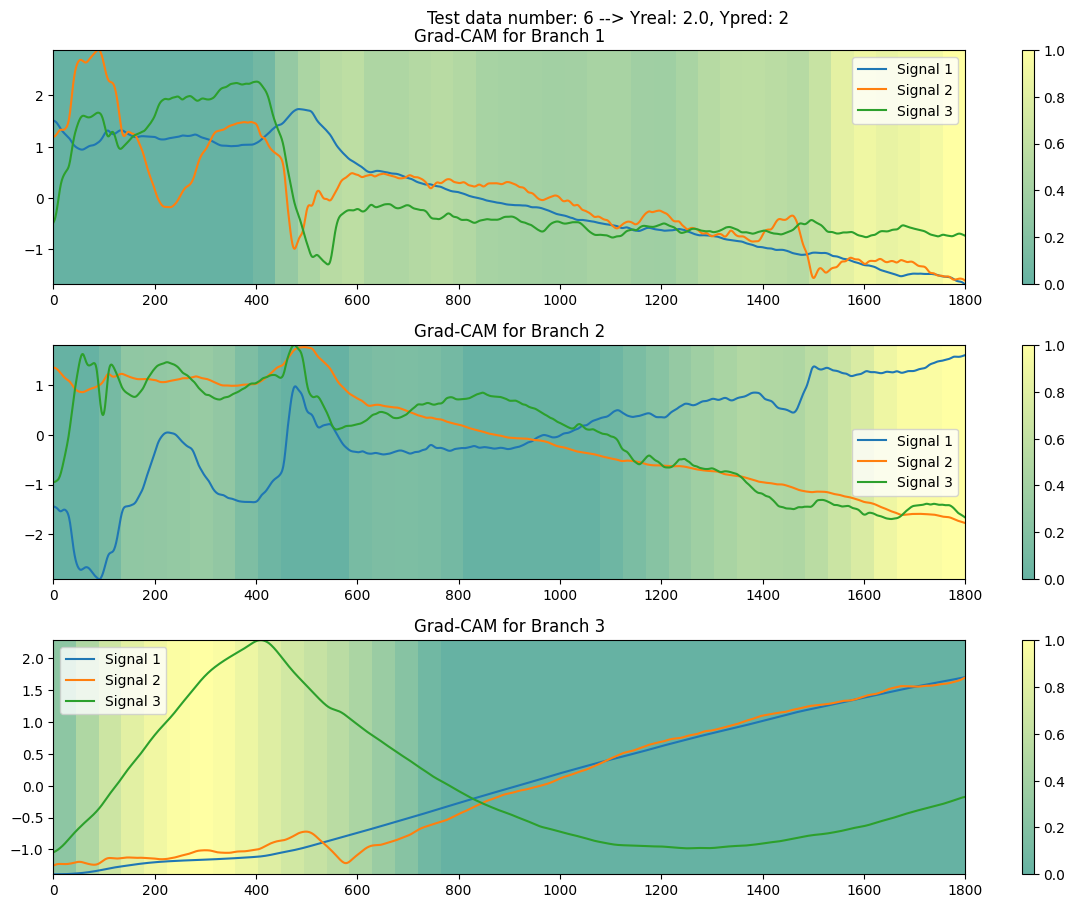

In [41]:

layer_names = ['conv3_forces_1D', 'conv2_torques_1D', 'conv2_deltaPoses_1D']
plot_grad_cam(model, _X_test, 6, y_test, layer_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


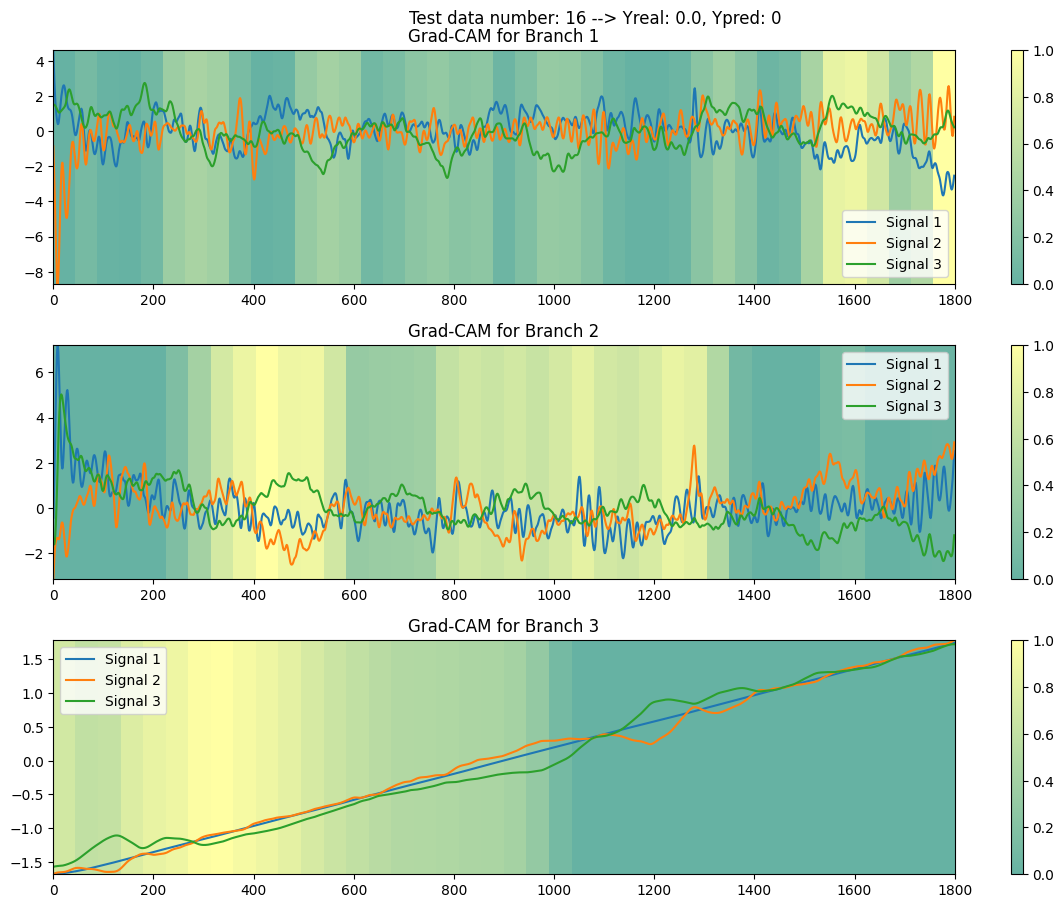

In [5]:
layer_names = ['conv3_forces_1D', 'conv2_torques_1D', 'conv2_deltaPoses_1D']
plot_grad_cam(model, _X_test, 16, y_test, layer_names)

Model: "MultiBranchModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_forces_1D     │ (None, 1800, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_forces_1D     │ (None, 178, 64)   │      5,824 │ input_forces_1D[… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 178, 64)   │          0 │ conv1_forces_1D[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_torques_1D    │ (None, 1800, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_deltaPoses_1D │ (None, 1800, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_forces_2D     │ (None, 1800, 384, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_torques_2D    │ (None, 1800, 384, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 178, 64)   │          0 │ activation_11[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_torques_1D    │ (None, 177, 64)   │      7,744 │ input_torques_1D… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_deltaPoses_1D │ (None, 177, 64)   │      7,744 │ input_deltaPoses… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_forces_2D     │ (None, 225, 48,   │      6,464 │ input_forces_2D[… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_torques_2D    │ (None, 225, 48,   │     25,664 │ input_torques_2D… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_forces_1D     │ (None, 43, 128)   │     82,048 │ dropout_10[0][0]  │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 177, 64)   │          0 │ conv1_torques_1D… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 177, 64)   │          0 │ conv1_deltaPoses… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 225, 48,   │          0 │ conv1_forces_2D[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 225, 48,   │          0 │ conv1_torques_2D

 Total params: 1,717,764 (6.55 MB)

 Trainable params: 1,717,764 (6.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 952ms/step - accuracy: 0.2648 - loss: 1.6100 - val_accuracy: 0.6774 - val_loss: 0.9520
Epoch 2/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6044 - loss: 0.9507 - val_accuracy: 0.8172 - val_loss: 0.5948
Epoch 3/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8168 - loss: 0.5728 - val_accuracy: 0.8495 - val_loss: 0.5059
Epoch 4/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8519 - loss: 0.4012 - val_accuracy: 0.8602 - val_loss: 0.4106
Epoch 5/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8740 - loss: 0.3066 - val_accuracy: 0.8172 - val_loss: 0.5077
Epoch 6/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8965 - loss: 0.2405 - val_accuracy: 0.8602 - val_loss: 0.3884
Epoch 7/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9266 - loss: 0.2226 - val_accuracy: 0.7742 - val_loss: 0.6033
Epoch 8/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8218 - loss: 0.4376 - val_accuracy: 0.8280 - val_loss: 0.451

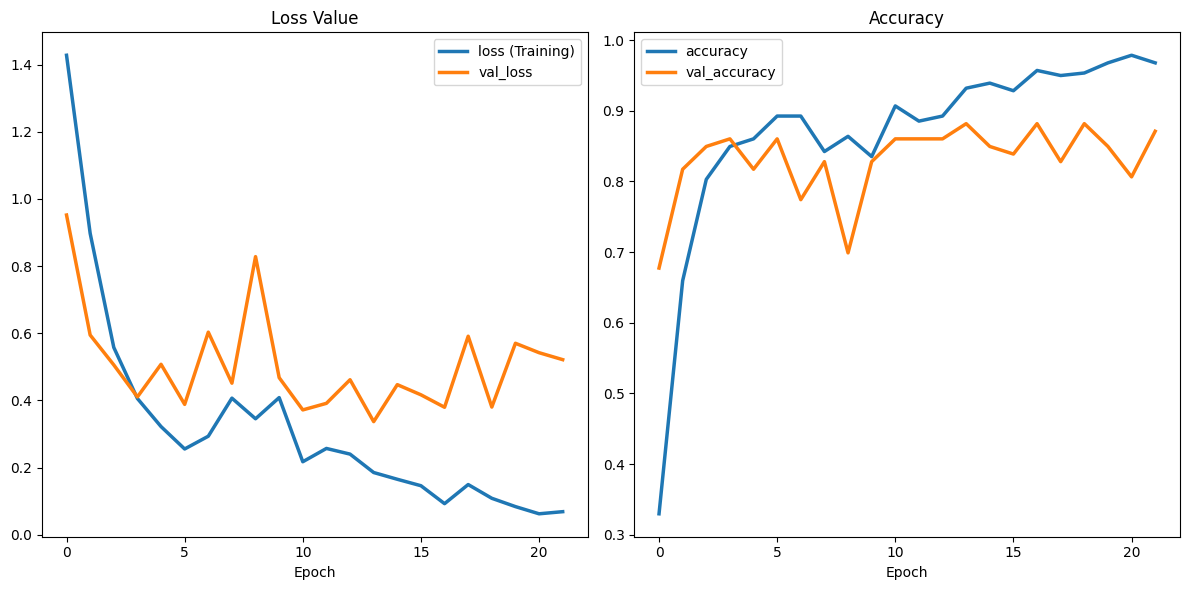

Test loss: 0.1269138753414154
Test accuracy: 0.946236559139785
F1 Score: 0.9400252525252525
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        29
         1.0       0.95      0.95      0.95        22
         2.0       0.85      1.00      0.92        22
         3.0       1.00      0.80      0.89        20

    accuracy                           0.95        93
   macro avg       0.95      0.94      0.94        93
weighted avg       0.95      0.95      0.95        93



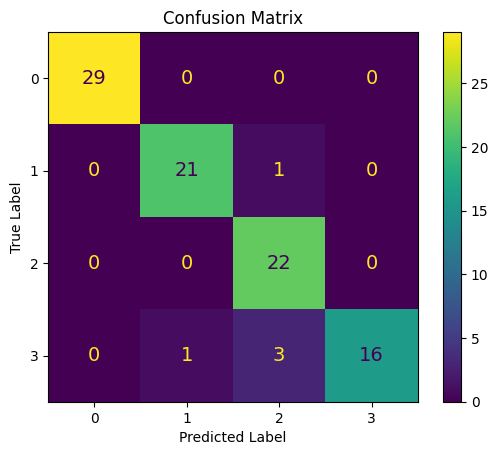

In [6]:
def build_MultiBranchModel(F_input_shape, T_input_shape, P_input_shape, S_input_shape_F, S_input_shape_T, num_classes):
    # 1D Force Branch
    input_forces_1D = tf.keras.layers.Input(shape=F_input_shape, name='input_forces_1D')
    conv1_forces_1D = tf.keras.layers.Conv1D(64, kernel_size=30, strides=10, name='conv1_forces_1D')(input_forces_1D)
    conv1_forces_1D = tf.keras.layers.Activation('relu')(conv1_forces_1D)
    dropout1_forces_1D = tf.keras.layers.Dropout(0.1)(conv1_forces_1D)
    conv2_forces_1D = tf.keras.layers.Conv1D(128, kernel_size=10, strides=4, name='conv2_forces_1D')(dropout1_forces_1D)
    conv2_forces_1D = tf.keras.layers.Activation('relu')(conv2_forces_1D)
    dropout2_forces_1D = tf.keras.layers.Dropout(0.1)(conv2_forces_1D)
    conv3_forces_1D = tf.keras.layers.Conv1D(256, kernel_size=3, strides=1, name='conv3_forces_1D')(dropout2_forces_1D)
    conv3_forces_1D = tf.keras.layers.Activation('relu')(conv3_forces_1D)
    pool1_forces_1D = tf.keras.layers.GlobalMaxPooling1D()(conv3_forces_1D)

    flatten_forces_1D = tf.keras.layers.Flatten()(pool1_forces_1D)

    # 1D Torque Branch
    input_torques_1D = tf.keras.layers.Input(shape=T_input_shape, name='input_torques_1D')
    conv1_torques_1D = tf.keras.layers.Conv1D(64, kernel_size=40, strides=10, name='conv1_torques_1D')(input_torques_1D)
    conv1_torques_1D = tf.keras.layers.Activation('relu')(conv1_torques_1D)
    dropout1_torques_1D = tf.keras.layers.Dropout(0.1)(conv1_torques_1D)
    conv2_torques_1D = tf.keras.layers.Conv1D(128, kernel_size=20, strides=4, name='conv2_torques_1D')(dropout1_torques_1D)
    conv2_torques_1D = tf.keras.layers.Activation('relu')(conv2_torques_1D)
    dropout2_torques_1D = tf.keras.layers.Dropout(0.1)(conv2_torques_1D)
    pool1_torques_1D = tf.keras.layers.GlobalMaxPooling1D()(dropout2_torques_1D)

    flatten_torques_1D = tf.keras.layers.Flatten()(pool1_torques_1D)

    # 1D Delta Pose Branch
    input_deltaPoses_1D = tf.keras.layers.Input(shape=P_input_shape, name='input_deltaPoses_1D')
    conv1_deltaPoses_1D = tf.keras.layers.Conv1D(64, kernel_size=40, strides=10, name='conv1_deltaPoses_1D')(input_deltaPoses_1D)
    conv1_deltaPoses_1D = tf.keras.layers.Activation('relu')(conv1_deltaPoses_1D)
    dropout1_deltaPoses_1D = tf.keras.layers.Dropout(0.1)(conv1_deltaPoses_1D)
    conv2_deltaPoses_1D = tf.keras.layers.Conv1D(128, kernel_size=20, strides=4, name='conv2_deltaPoses_1D')(dropout1_deltaPoses_1D)
    conv2_deltaPoses_1D = tf.keras.layers.Activation('relu')(conv2_deltaPoses_1D)
    dropout2_deltaPoses_1D = tf.keras.layers.Dropout(0.1)(conv2_deltaPoses_1D)
    pool1_deltaPoses_1D = tf.keras.layers.GlobalMaxPooling1D()(dropout2_deltaPoses_1D)

    flatten_deltaPoses_1D = tf.keras.layers.Flatten()(pool1_deltaPoses_1D)

    # 2D Force Scaleogram Branch
    input_forces_2D = tf.keras.layers.Input(shape=S_input_shape_F, name='input_forces_2D')
    conv1_forces_2D = tf.keras.layers.Conv2D(64, kernel_size=(10, 10), strides=(8, 8), padding='same', name='conv1_forces_2D')(input_forces_2D)
    conv1_forces_2D = tf.keras.layers.Activation('relu')(conv1_forces_2D)
    dropout1_forces_2D = tf.keras.layers.Dropout(0.1)(conv1_forces_2D)
    conv2_forces_2D = tf.keras.layers.Conv2D(128, kernel_size=(8, 8), strides=(4, 4), padding='same', name='conv2_forces_2D')(dropout1_forces_2D)
    conv2_forces_2D = tf.keras.layers.Activation('relu')(conv2_forces_2D)
    dropout2_forces_2D = tf.keras.layers.Dropout(0.1)(conv2_forces_2D)
    pool1_forces_2D = tf.keras.layers.GlobalMaxPooling2D()(dropout2_forces_2D)

    flatten_forces_2D = tf.keras.layers.Flatten()(pool1_forces_2D)

    # 2D Torque Scaleogram Branch
    input_torques_2D = tf.keras.layers.Input(shape=S_input_shape_T, name='input_torques_2D')
    conv1_torques_2D = tf.keras.layers.Conv2D(64, kernel_size=(20, 20), strides=(8, 8), padding='same', name='conv1_torques_2D')(input_torques_2D)
    conv1_torques_2D = tf.keras.layers.Activation('relu')(conv1_torques_2D)
    dropout1_torques_2D = tf.keras.layers.Dropout(0.1)(conv1_torques_2D)
    conv2_torques_2D = tf.keras.layers.Conv2D(128, kernel_size=(8, 8), strides=(4, 4), padding='same', name='conv2_torques_2D')(dropout1_torques_2D)
    conv2_torques_2D = tf.keras.layers.Activation('relu')(conv2_torques_2D)
    dropout2_torques_2D = tf.keras.layers.Dropout(0.1)(conv2_torques_2D)
    pool1_torques_2D = tf.keras.layers.GlobalMaxPooling2D()(dropout2_torques_2D)

    flatten_torques_2D = tf.keras.layers.Flatten()(pool1_torques_2D)

    # Merge all branches
    merged = tf.keras.layers.concatenate([
        flatten_forces_1D, flatten_torques_1D, 
        flatten_deltaPoses_1D, flatten_forces_2D, flatten_torques_2D
    ])

    # Fully Connected Layers
    fc = tf.keras.layers.Dense(128, activation='relu')(merged)
    fc = tf.keras.layers.Dense(64, activation='relu')(fc)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(fc)

    # Define the Model
    model = tf.keras.Model(
        inputs=[
            input_forces_1D, input_torques_1D, 
            input_deltaPoses_1D, input_forces_2D, input_torques_2D
        ], 
        outputs=output, 
        name='MultiBranchModel'
    )
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

'''
def assign_and_deploy_variables(data_dict):
    for key, data in data_dict.items():
        globals()[f"{key}1"] = np.dstack((data[:, :, 1], data[:, :, 4]))
        globals()[f"{key}2"] = data[:, :, 1]
        globals()[f"{key}3"] = np.dstack((data[:, :, 2], data[:, :, 5]))
        globals()[f"{key}4"] = np.dstack((data[:, :, 6], data[:, :, 7], data[:, :, 8]))
'''

# Define input shapes based on the above structure
F_input_shape = (target_length, 3)  # For the 1D branch (forces)
T_input_shape = (target_length, 3)  # For the 1D branch (torques)
P_input_shape = (target_length, 3)  # For the 1D branch (delta poses)

# The 2D branches use the scaleogram input shapes
S_input_shape_F = (target_length, scales_dim*3, 1)  # For the 2D branch (force scaleograms)
S_input_shape_T = (target_length, scales_dim*3, 1)  # For the 2D branch (torque scaleograms)

# X_train = np.array(X_train)
# X_val = np.array(X_val)
# X_test = np.array(X_test)

X_train_1D_forces = X_train[:, :, 0:3]  # Force_X, Force_Y, Force_Z
X_train_1D_torques = X_train[:, :, 3:6]  # Torque_X, Torque_Y, Torque_Z
X_train_1D_deltaPoses = X_train[:, :, 6:9]  # Pose_X, Pose_Y, Pose_Z

X_val_1D_forces = X_val[:, :, 0:3]
X_val_1D_torques = X_val[:, :, 3:6]
X_val_1D_deltaPoses = X_val[:, :, 6:9]

X_test_1D_forces = X_test[:, :, 0:3]
X_test_1D_torques = X_test[:, :, 3:6]
X_test_1D_deltaPoses = X_test[:, :, 6:9]

# Separate the 2D features: The remaining features are for scaleograms
X_train_2D = X_train[:, :, num_1D_features:]  # (samples, target_length, 768)
X_val_2D = X_val[:, :, num_1D_features:]
X_test_2D = X_test[:, :, num_1D_features:]

# Reshape the 2D features to have a shape of (samples, target_length, scales_dim, 1)
X_train_2D_forces = X_train_2D[:, :, 0:3*scales_dim].reshape(-1, target_length, 3*scales_dim, 1)
X_train_2D_torques = X_train_2D[:, :, 3*scales_dim:6*scales_dim].reshape(-1, target_length, 3*scales_dim, 1)

X_val_2D_forces = X_val_2D[:, :, 0:3*scales_dim].reshape(-1, target_length, 3*scales_dim, 1)
X_val_2D_torques = X_val_2D[:, :, 3*scales_dim:6*scales_dim].reshape(-1, target_length, 3*scales_dim, 1)

X_test_2D_forces = X_test_2D[:, :, 0:3*scales_dim].reshape(-1, target_length, 3*scales_dim, 1)
X_test_2D_torques = X_test_2D[:, :, 3*scales_dim:6*scales_dim].reshape(-1, target_length, 3*scales_dim, 1)

# Now you can organize the data as required
_X_train = [X_train_1D_forces, X_train_1D_torques, X_train_1D_deltaPoses, X_train_2D_forces, X_train_2D_torques]
_X_val = [X_val_1D_forces, X_val_1D_torques, X_val_1D_deltaPoses, X_val_2D_forces, X_val_2D_torques]
_X_test = [X_test_1D_forces, X_test_1D_torques, X_test_1D_deltaPoses, X_test_2D_forces, X_test_2D_torques]
# Create and compile the model
model = build_MultiBranchModel(F_input_shape, T_input_shape, P_input_shape, S_input_shape_F, S_input_shape_T, num_classes)
model.summary()
history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(
    model, _X_train, y_train, _X_val, y_val, _X_test, y_test, 
    epochs=70, batch_size=32, patience=8, disp_labels=DISP_LABELS
)


# 1D SPEED INSPIRED HYBRID

Model: "MultiBranchModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_forces_1D     │ (None, 1800, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_additional_1D │ (None, 1800, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_forces_1D     │ (None, 178, 64)   │      3,904 │ input_forces_1D[… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_additional_1D │ (None, 178, 64)   │      5,824 │ input_additional… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 178, 64)   │          0 │ conv1_forces_1D[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_torques_1D    │ (None, 1800, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_deltaPoses_1D │ (None, 1800, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 178, 64)   │          0 │ conv1_additional… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_forces_2D     │ (None, 1800, 256, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_torques_2D    │ (None, 1800, 128, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_deltaPoses_2D │ (None, 1800, 256, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 178, 64)   │          0 │ activation_22[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_torques_1D    │ (None, 177, 64)   │      2,624 │ input_torques_1D… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_deltaPoses_1D │ (None, 177, 64)   │      5,184 │ input_deltaPoses… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 178, 64)   │          0 │ activation_29[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_forces_2D     │ (None, 225, 32,   │      6,464 │ input_forces_2D[… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_torques_2D    │ (None, 225, 16,   │     25,664 │ input_torques_2D

 Total params: 2,474,628 (9.44 MB)

 Trainable params: 2,474,628 (9.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.2477 - loss: 1.6811 - val_accuracy: 0.5054 - val_loss: 1.1184
Epoch 2/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6361 - loss: 0.9430 - val_accuracy: 0.6129 - val_loss: 0.9449
Epoch 3/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7415 - loss: 0.6762 - val_accuracy: 0.6989 - val_loss: 0.6772
Epoch 4/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7651 - loss: 0.6307 - val_accuracy: 0.8710 - val_loss: 0.4684
Epoch 5/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8006 - loss: 0.4679 - val_accuracy: 0.8495 - val_loss: 0.4675
Epoch 6/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8063 - loss: 0.6064 - val_accuracy: 0.7957 - val_loss: 0.5710
Epoch 7/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9035 - loss: 0.3051 - val_accuracy: 0.8172 - val_loss: 0.3874
Epoch 8/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8638 - loss: 0.2809 - val_accuracy: 0.8817 - val_loss: 0.3381
E

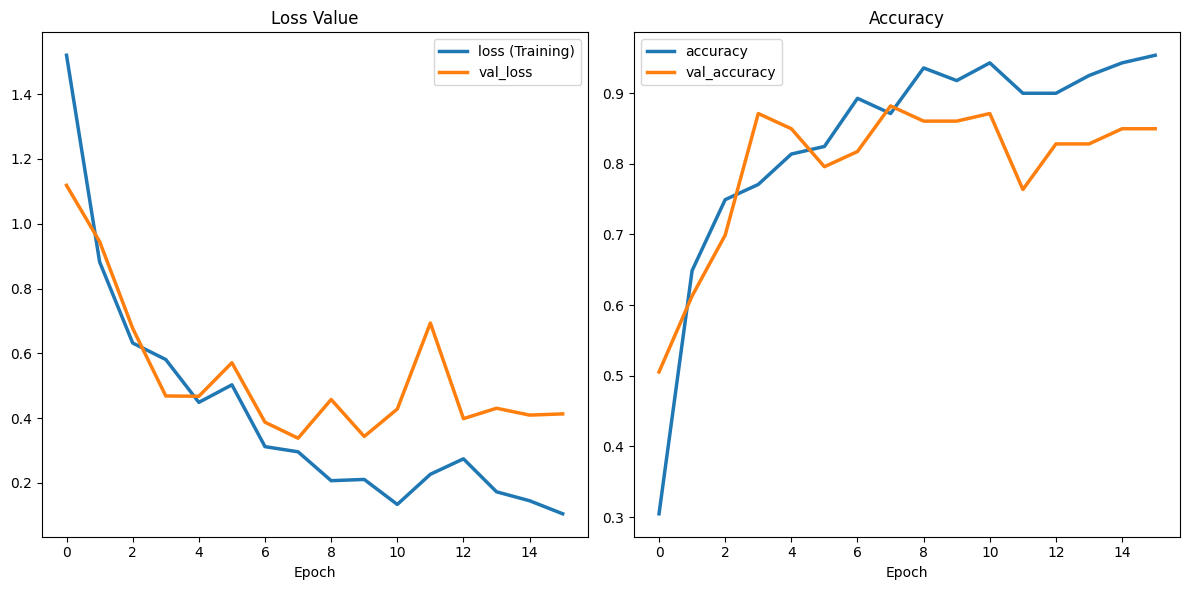

Test loss: 0.25076159834861755
Test accuracy: 0.9139784946236559
F1 Score: 0.9052871148459383
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.93      0.96        29
         1.0       0.85      1.00      0.92        22
         2.0       0.85      1.00      0.92        22
         3.0       1.00      0.70      0.82        20

    accuracy                           0.91        93
   macro avg       0.92      0.91      0.91        93
weighted avg       0.93      0.91      0.91        93



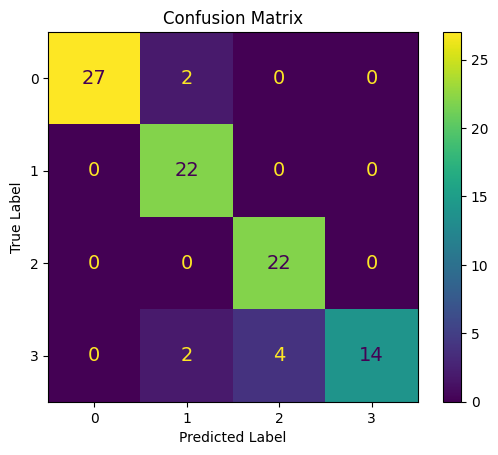

In [7]:
import tensorflow as tf

def build_MultiBranchModel(F1D_shape, T1D_shape, P1D_shape, A1D_shape, F2D_shape, T2D_shape, P2D_shape, num_classes):
    # 1D Force Branch
    input_forces_1D = tf.keras.layers.Input(shape=F1D_shape, name='input_forces_1D')
    conv1_forces_1D = tf.keras.layers.Conv1D(64, kernel_size=30, strides=10, name='conv1_forces_1D')(input_forces_1D)
    conv1_forces_1D = tf.keras.layers.Activation('relu')(conv1_forces_1D)
    dropout1_forces_1D = tf.keras.layers.Dropout(0.1)(conv1_forces_1D)
    conv2_forces_1D = tf.keras.layers.Conv1D(128, kernel_size=10, strides=4, name='conv2_forces_1D')(dropout1_forces_1D)
    conv2_forces_1D = tf.keras.layers.Activation('relu')(conv2_forces_1D)
    dropout2_forces_1D = tf.keras.layers.Dropout(0.1)(conv2_forces_1D)
    conv3_forces_1D = tf.keras.layers.Conv1D(256, kernel_size=3, strides=1, name='conv3_forces_1D')(dropout2_forces_1D)
    conv3_forces_1D = tf.keras.layers.Activation('relu')(conv3_forces_1D)
    pool1_forces_1D = tf.keras.layers.GlobalMaxPooling1D()(conv3_forces_1D)
    flatten_forces_1D = tf.keras.layers.Flatten()(pool1_forces_1D)

    # 1D Torque Branch
    input_torques_1D = tf.keras.layers.Input(shape=T1D_shape, name='input_torques_1D')
    conv1_torques_1D = tf.keras.layers.Conv1D(64, kernel_size=40, strides=10, name='conv1_torques_1D')(input_torques_1D)
    conv1_torques_1D = tf.keras.layers.Activation('relu')(conv1_torques_1D)
    dropout1_torques_1D = tf.keras.layers.Dropout(0.1)(conv1_torques_1D)
    conv2_torques_1D = tf.keras.layers.Conv1D(128, kernel_size=20, strides=4, name='conv2_torques_1D')(dropout1_torques_1D)
    conv2_torques_1D = tf.keras.layers.Activation('relu')(conv2_torques_1D)
    dropout2_torques_1D = tf.keras.layers.Dropout(0.1)(conv2_torques_1D)
    pool1_torques_1D = tf.keras.layers.GlobalMaxPooling1D()(dropout2_torques_1D)
    flatten_torques_1D = tf.keras.layers.Flatten()(pool1_torques_1D)

    # 1D Delta Pose Branch
    input_deltaPoses_1D = tf.keras.layers.Input(shape=P1D_shape, name='input_deltaPoses_1D')
    conv1_deltaPoses_1D = tf.keras.layers.Conv1D(64, kernel_size=40, strides=10, name='conv1_deltaPoses_1D')(input_deltaPoses_1D)
    conv1_deltaPoses_1D = tf.keras.layers.Activation('relu')(conv1_deltaPoses_1D)
    dropout1_deltaPoses_1D = tf.keras.layers.Dropout(0.1)(conv1_deltaPoses_1D)
    conv2_deltaPoses_1D = tf.keras.layers.Conv1D(128, kernel_size=20, strides=4, name='conv2_deltaPoses_1D')(dropout1_deltaPoses_1D)
    conv2_deltaPoses_1D = tf.keras.layers.Activation('relu')(conv2_deltaPoses_1D)
    dropout2_deltaPoses_1D = tf.keras.layers.Dropout(0.1)(conv2_deltaPoses_1D)
    pool1_deltaPoses_1D = tf.keras.layers.GlobalMaxPooling1D()(dropout2_deltaPoses_1D)
    flatten_deltaPoses_1D = tf.keras.layers.Flatten()(pool1_deltaPoses_1D)

    # 1D Additional Branch (e.g., Acceleration or any other)
    input_additional_1D = tf.keras.layers.Input(shape=A1D_shape, name='input_additional_1D')
    conv1_additional_1D = tf.keras.layers.Conv1D(64, kernel_size=30, strides=10, name='conv1_additional_1D')(input_additional_1D)
    conv1_additional_1D = tf.keras.layers.Activation('relu')(conv1_additional_1D)
    dropout1_additional_1D = tf.keras.layers.Dropout(0.1)(conv1_additional_1D)
    conv2_additional_1D = tf.keras.layers.Conv1D(128, kernel_size=10, strides=4, name='conv2_additional_1D')(dropout1_additional_1D)
    conv2_additional_1D = tf.keras.layers.Activation('relu')(conv2_additional_1D)
    dropout2_additional_1D = tf.keras.layers.Dropout(0.1)(conv2_additional_1D)
    conv3_additional_1D = tf.keras.layers.Conv1D(256, kernel_size=3, strides=1, name='conv3_additional_1D')(dropout2_additional_1D)
    conv3_additional_1D = tf.keras.layers.Activation('relu')(conv3_additional_1D)
    pool1_additional_1D = tf.keras.layers.GlobalMaxPooling1D()(conv3_additional_1D)
    flatten_additional_1D = tf.keras.layers.Flatten()(pool1_additional_1D)

    # 2D Force Scaleogram Branch
    input_forces_2D = tf.keras.layers.Input(shape=F2D_shape, name='input_forces_2D')
    conv1_forces_2D = tf.keras.layers.Conv2D(64, kernel_size=(10, 10), strides=(8, 8), padding='same', name='conv1_forces_2D')(input_forces_2D)
    conv1_forces_2D = tf.keras.layers.Activation('relu')(conv1_forces_2D)
    dropout1_forces_2D = tf.keras.layers.Dropout(0.1)(conv1_forces_2D)
    conv2_forces_2D = tf.keras.layers.Conv2D(128, kernel_size=(8, 8), strides=(4, 4), padding='same', name='conv2_forces_2D')(dropout1_forces_2D)
    conv2_forces_2D = tf.keras.layers.Activation('relu')(conv2_forces_2D)
    dropout2_forces_2D = tf.keras.layers.Dropout(0.1)(conv2_forces_2D)
    pool1_forces_2D = tf.keras.layers.GlobalMaxPooling2D()(dropout2_forces_2D)
    flatten_forces_2D = tf.keras.layers.Flatten()(pool1_forces_2D)

    # 2D Torque Scaleogram Branch
    input_torques_2D = tf.keras.layers.Input(shape=T2D_shape, name='input_torques_2D')
    conv1_torques_2D = tf.keras.layers.Conv2D(64, kernel_size=(20, 20), strides=(8, 8), padding='same', name='conv1_torques_2D')(input_torques_2D)
    conv1_torques_2D = tf.keras.layers.Activation('relu')(conv1_torques_2D)
    dropout1_torques_2D = tf.keras.layers.Dropout(0.1)(conv1_torques_2D)
    conv2_torques_2D = tf.keras.layers.Conv2D(128, kernel_size=(8, 8), strides=(4, 4), padding='same', name='conv2_torques_2D')(dropout1_torques_2D)
    conv2_torques_2D = tf.keras.layers.Activation('relu')(conv2_torques_2D)
    dropout2_torques_2D = tf.keras.layers.Dropout(0.1)(conv2_torques_2D)
    pool1_torques_2D = tf.keras.layers.GlobalMaxPooling2D()(dropout2_torques_2D)
    flatten_torques_2D = tf.keras.layers.Flatten()(pool1_torques_2D)

    # 2D Delta Pose Scaleogram Branch
    input_deltaPoses_2D = tf.keras.layers.Input(shape=P2D_shape, name='input_deltaPoses_2D')
    conv1_deltaPoses_2D = tf.keras.layers.Conv2D(64, kernel_size=(10, 10), strides=(8, 8), padding='same', name='conv1_deltaPoses_2D')(input_deltaPoses_2D)
    conv1_deltaPoses_2D = tf.keras.layers.Activation('relu')(conv1_deltaPoses_2D)
    dropout1_deltaPoses_2D = tf.keras.layers.Dropout(0.1)(conv1_deltaPoses_2D)
    conv2_deltaPoses_2D = tf.keras.layers.Conv2D(128, kernel_size=(8, 8), strides=(4, 4), padding='same', name='conv2_deltaPoses_2D')(dropout1_deltaPoses_2D)
    conv2_deltaPoses_2D = tf.keras.layers.Activation('relu')(conv2_deltaPoses_2D)
    dropout2_deltaPoses_2D = tf.keras.layers.Dropout(0.1)(conv2_deltaPoses_2D)
    pool1_deltaPoses_2D = tf.keras.layers.GlobalMaxPooling2D()(dropout2_deltaPoses_2D)
    flatten_deltaPoses_2D = tf.keras.layers.Flatten()(pool1_deltaPoses_2D)

    # Merge all branches
    merged = tf.keras.layers.concatenate([
        flatten_forces_1D, flatten_torques_1D, flatten_deltaPoses_1D, flatten_additional_1D,
        flatten_forces_2D, flatten_torques_2D, flatten_deltaPoses_2D
    ])

    # Fully Connected Layers
    fc = tf.keras.layers.Dense(128, activation='relu')(merged)
    fc = tf.keras.layers.Dense(64, activation='relu')(fc)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(fc)

    # Define the Model
    model = tf.keras.Model(
        inputs=[
            input_forces_1D, input_torques_1D, input_deltaPoses_1D, input_additional_1D, 
            input_forces_2D, input_torques_2D, input_deltaPoses_2D
        ], 
        outputs=output, 
        name='MultiBranchModel'
    )
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


import numpy as np

# def assign_and_deploy_variables(data_dict):
#     for key, data in data_dict.items():
#         # For 1D inputs (Force, Torque, Delta Poses)
#         globals()[f"{key}1"] = data[:, :, 0:2]  # For the 1D branch (forces - size (1800, 2))
#         globals()[f"{key}2"] = data[:, :, 2:3]  # For the 1D branch (torques - size (1800, 1))
#         globals()[f"{key}3"] = data[:, :, 3:5]  # For the 1D branch (delta poses - size (1800, 2))
#         globals()[f"{key}4"] = data[:, :, 5:8]  # For the 1D branch (additional features - size (1800, 3))

#         # For 2D inputs (Scaleograms)
#         globals()[f"{key}_2D1"] = data[:, :, 8:8+(2*128)].reshape(-1, 1800, 2*128, 1)  # Forces scaleogram - size (1800, 2*128)
#         globals()[f"{key}_2D2"] = data[:, :, 8+(2*128):8+(3*128)].reshape(-1, 1800, 1*128, 1)  # Torques scaleogram - size (1800, 1*128)
#         globals()[f"{key}_2D3"] = data[:, :, 8+(3*128):8+(5*128)].reshape(-1, 1800, 2*128, 1)  # Delta poses scaleogram - size (1800, 2*128)

# Define input shapes based on your structure
F_input_shape = (1800, 2)  # For the 1D branch (forces)
T_input_shape = (1800, 1)  # For the 1D branch (torques)
P_input_shape = (1800, 2)  # For the 1D branch (delta poses)
A_input_shape = (1800, 3)  # For the 1D branch (additional features)

# The 2D branches use the scaleogram input shapes
S_input_shape_F = (1800, 2*128, 1)  # For the 2D branch (force scaleograms)
S_input_shape_T = (1800, 1*128, 1)  # For the 2D branch (torque scaleograms)
S_input_shape_P = (1800, 2*128, 1)  # For the 2D branch (delta poses scaleograms)

# Assume X_train, X_val, X_test are the raw datasets loaded from files
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# 1D inputs using adapted element selections
X_train_1D_forces = np.dstack((X_train[:, :, 1], X_train[:, :, 4]))  # Selected columns 1 and 4
X_train_1D_torques = X_train[:, :, 1]  # Selected column 1
X_train_1D_deltaPoses = np.dstack((X_train[:, :, 2], X_train[:, :, 5]))  # Selected columns 2 and 5
X_train_1D_additional = np.dstack((X_train[:, :, 6], X_train[:, :, 7], X_train[:, :, 8]))  # Selected columns 6, 7, and 8

X_val_1D_forces = np.dstack((X_val[:, :, 1], X_val[:, :, 4]))  # Selected columns 1 and 4
X_val_1D_torques = X_val[:, :, 1]  # Selected column 1
X_val_1D_deltaPoses = np.dstack((X_val[:, :, 2], X_val[:, :, 5]))  # Selected columns 2 and 5
X_val_1D_additional = np.dstack((X_val[:, :, 6], X_val[:, :, 7], X_val[:, :, 8]))  # Selected columns 6, 7, and 8

X_test_1D_forces = np.dstack((X_test[:, :, 1], X_test[:, :, 4]))  # Selected columns 1 and 4
X_test_1D_torques = X_test[:, :, 1]  # Selected column 1
X_test_1D_deltaPoses = np.dstack((X_test[:, :, 2], X_test[:, :, 5]))  # Selected columns 2 and 5
X_test_1D_additional = np.dstack((X_test[:, :, 6], X_test[:, :, 7], X_test[:, :, 8]))  # Selected columns 6, 7, and 8


# 2D inputs using adapted element selections and multiplying for 128
X_train_2D_forces = np.dstack((X_train_2D[:, :, 1*128:(1*128)+128], X_train_2D[:, :, 4*128:(4*128)+128])).reshape(-1, 1800, 2*128, 1)  # Selected columns 1*128 and 4*128
X_train_2D_torques = X_train_2D[:, :, 1*128:(1*128)+128].reshape(-1, 1800, 1*128, 1)  # Selected column 1*128
X_train_2D_deltaPoses = np.dstack((X_train_2D[:, :, 2*128:(2*128)+128], X_train_2D[:, :, 5*128:(5*128)+128])).reshape(-1, 1800, 2*128, 1)  # Selected columns 2*128 and 5*128

X_val_2D_forces = np.dstack((X_val_2D[:, :, 1*128:(1*128)+128], X_val_2D[:, :, 4*128:(4*128)+128])).reshape(-1, 1800, 2*128, 1)  # Selected columns 1*128 and 4*128
X_val_2D_torques = X_val_2D[:, :, 1*128:(1*128)+128].reshape(-1, 1800, 1*128, 1)  # Selected column 1*128
X_val_2D_deltaPoses = np.dstack((X_val_2D[:, :, 2*128:(2*128)+128], X_val_2D[:, :, 5*128:(5*128)+128])).reshape(-1, 1800, 2*128, 1)  # Selected columns 2*128 and 5*128

X_test_2D_forces = np.dstack((X_test_2D[:, :, 1*128:(1*128)+128], X_test_2D[:, :, 4*128:(4*128)+128])).reshape(-1, 1800, 2*128, 1)  # Selected columns 1*128 and 4*128
X_test_2D_torques = X_test_2D[:, :, 1*128:(1*128)+128].reshape(-1, 1800, 1*128, 1)  # Selected column 1*128
X_test_2D_deltaPoses = np.dstack((X_test_2D[:, :, 2*128:(2*128)+128], X_test_2D[:, :, 5*128:(5*128)+128])).reshape(-1, 1800, 2*128, 1)  # Selected columns 2*128 and 5*128


# Organize the data as required
_X_train = [
    X_train_1D_forces, X_train_1D_torques, X_train_1D_deltaPoses, X_train_1D_additional, 
    X_train_2D_forces, X_train_2D_torques, X_train_2D_deltaPoses
]
_X_val = [
    X_val_1D_forces, X_val_1D_torques, X_val_1D_deltaPoses, X_val_1D_additional,
    X_val_2D_forces, X_val_2D_torques, X_val_2D_deltaPoses
]
_X_test = [
    X_test_1D_forces, X_test_1D_torques, X_test_1D_deltaPoses, X_test_1D_additional, 
    X_test_2D_forces, X_test_2D_torques, X_test_2D_deltaPoses
]

# Create and compile the model
model = build_MultiBranchModel(
    F_input_shape, T_input_shape, P_input_shape, A_input_shape, 
    S_input_shape_F, S_input_shape_T, S_input_shape_P, num_classes
)
model.summary()

# Train and evaluate the model
history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(
    model, _X_train, y_train, _X_val, y_val, _X_test, y_test, 
    epochs=70, batch_size=32, patience=8, disp_labels=DISP_LABELS
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


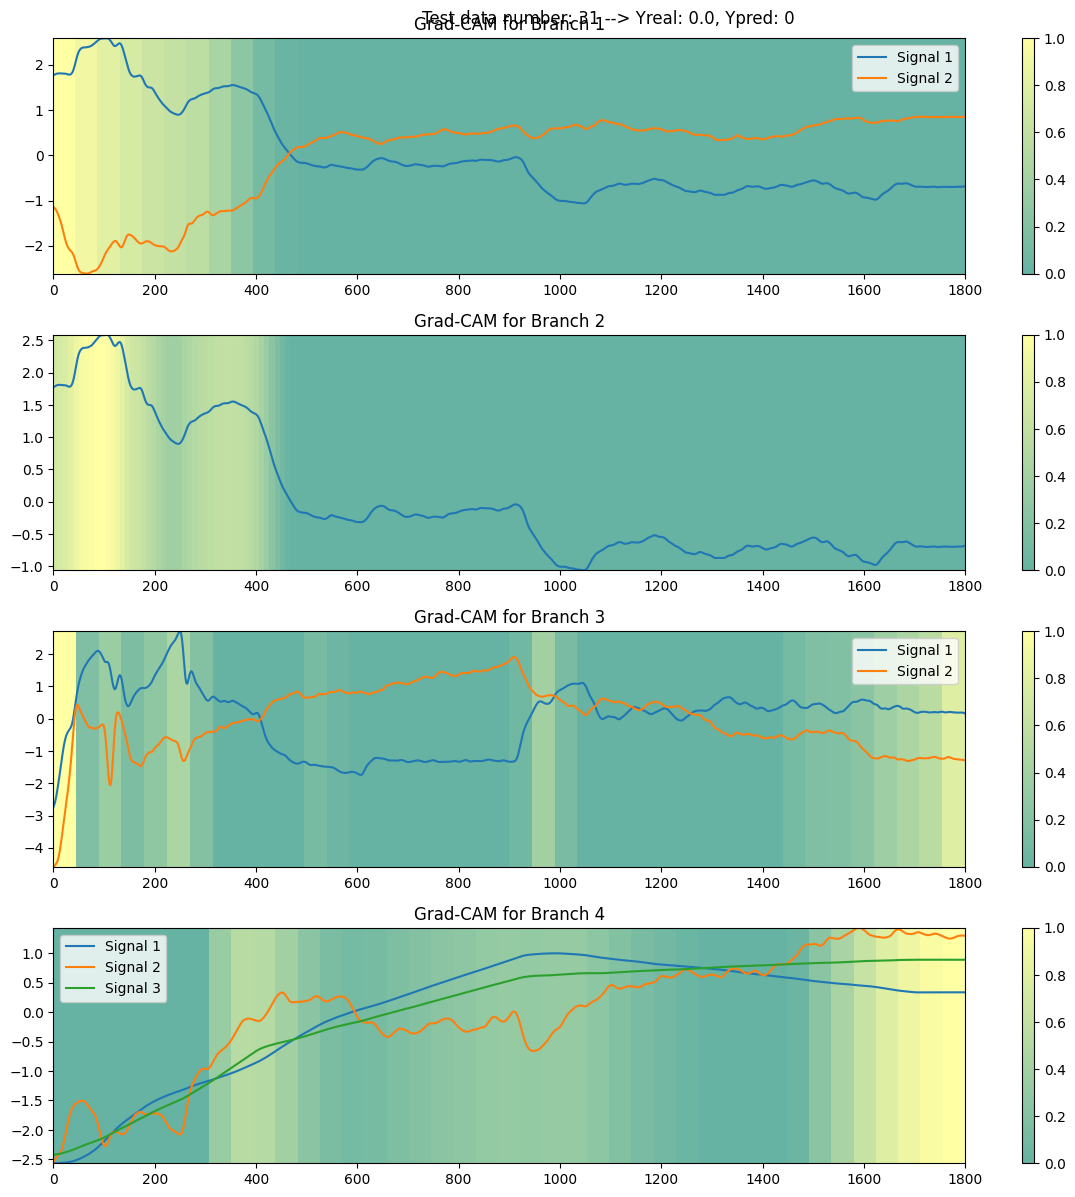

In [8]:
layer_names = ['conv3_forces_1D', 'conv1_torques_1D', 'conv2_deltaPoses_1D', 'conv3_additional_1D']

# Assuming you have a function plot_grad_cam that takes these parameters
plot_grad_cam(model, _X_test, 31, y_test, layer_names)
